# Installing Dependencies 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

```ruby
!pip install segmentation_models 
!pip install numpy==1.19.5
```

#### As tensorflow version in segmentation_model and latest version in google colab are not matching and creating error while training   


In [ ]:
#!pip install numpy==1.19.5        

     |████████████████████████████████| 14.8 MB 8.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Installing `segmentation_models`it contains segmentation models with pre-trained backbones with Keras.

**It contains:-**
- Unet
- FPN
- Linknet
- PSPNet

**Types of backbone**

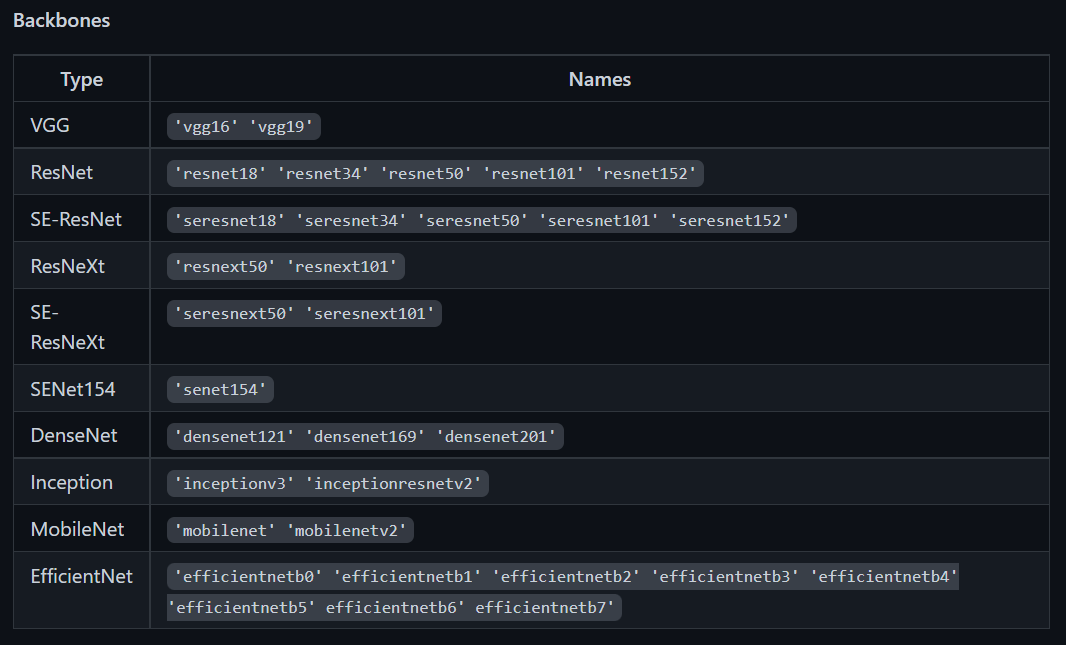


`All backbones have weights trained on 2012 ILSVRC ImageNet dataset (encoder_weights='imagenet').
`

In [ ]:
#!pip install segmentation_models 

     |████████████████████████████████| 50 kB 6.4 MB/s 


In [ ]:
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import Model
import os
import cv2
import glob
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical 
from keras.utils.np_utils import normalize
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

In [ ]:
import segmentation_models as sm

ModuleNotFoundError: ignored

In [ ]:
print(np.version.version)

1.19.5


In [ ]:
HEIGHT = 128 
WIDTH = 128
n_classes=9

In [ ]:
path = '/content/drive/MyDrive/Annotated Images/'

In [ ]:
image_dir = path
mask_dir = path

In [ ]:
#image
image_dataset = []
for path, subdirs, files in os.walk(image_dir): 
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'JPEGImages':  
        image = os.listdir(path) 
        image.sort()
        for i, image_name in enumerate(image):
          if image_name.endswith(".jpg"):
            mask = cv2.imread(path+"/"+image_name, 1)
            mask = cv2.resize(mask, (HEIGHT, WIDTH), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
            image_dataset.append(mask)
train_image  = np.array(image_dataset)             

In [ ]:
train_image.shape

In [ ]:
mask_dataset = []  
for path, subdirs, files in os.walk(mask_dir): 
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'SegmentationClass':  
        masks = os.listdir(path) 
        masks.sort()
        for i, mask_name in enumerate(masks):
          if mask_name.endswith(".png"):
            mask = cv2.imread(path+"/"+mask_name, 0)
            mask = cv2.resize(mask, (HEIGHT, WIDTH), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
            mask_dataset.append(mask)
train_masks  = np.array(mask_dataset)             

In [ ]:
train_masks.shape

(200, 128, 128)

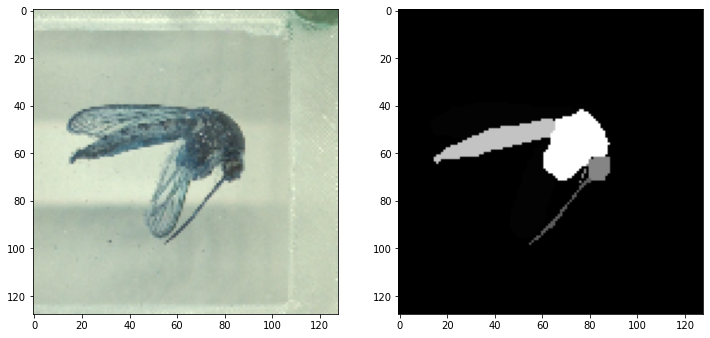

In [ ]:
import random

image_number = random.randint(0, len(train_image)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(train_image[image_number,:,:,:])
plt.subplot(122)
plt.imshow(train_masks[image_number,:,:], cmap='gray')
plt.show()

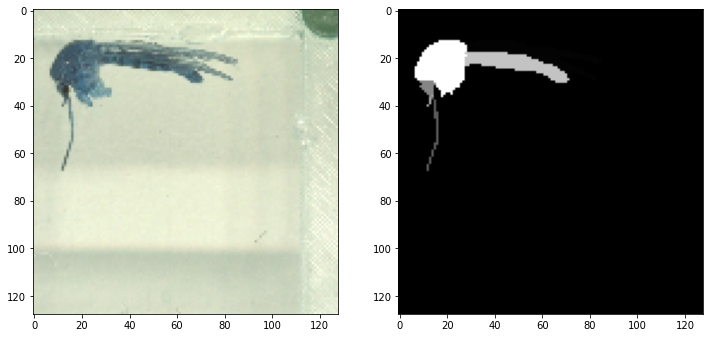

In [ ]:
import random

image_number = random.randint(0, len(train_image)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(train_image[image_number,:,:,:])
plt.subplot(122)
plt.imshow(train_masks[image_number,:,:], cmap='gray')
plt.show()

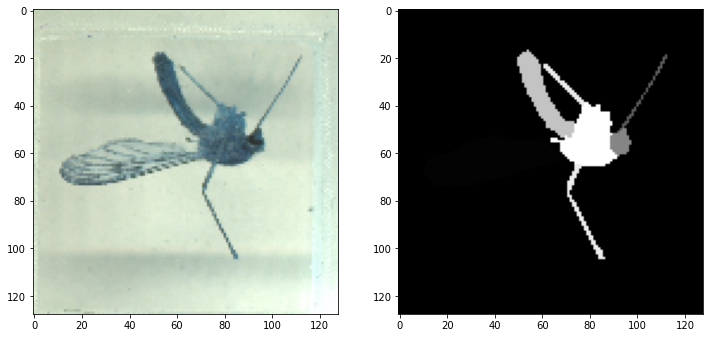

In [ ]:
import random

image_number = random.randint(0, len(train_image)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(train_image[image_number,:,:,:])
plt.subplot(122)
plt.imshow(train_masks[image_number,:,:], cmap='gray')
plt.show()

In [ ]:
np.unique(train_masks) 

array([  0,   3,  81, 118, 124, 147, 174, 210, 227], dtype=uint8)

In [ ]:
np.unique(train_masks).shape

(9,)

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
np.unique(train_masks_encoded_original_shape)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
train_masks_encoded_original_shape.shape

(200, 128, 128)

In [ ]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [ ]:
train_masks_input.shape

(200, 128, 128, 1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_image, train_masks_input, test_size = 0.20, random_state = 10)

In [ ]:
X_train.shape

(160, 128, 128, 3)

In [ ]:
y_train.shape

(160, 128, 128, 1)

In [ ]:
print("Class values in the dataset:-", np.unique(y_train))  # 0 is the background

Class values in the dataset:- [0 1 2 3 4 5 6 7 8]


In [ ]:
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))


test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
n_classes=9
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [ ]:
###Model 1
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', input_shape = (128,128,3), classes=n_classes, activation=activation)
# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)


print(model1.summary())

85532672/85521592 [==============================] - 4s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 128, 128, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)            

In [ ]:
history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=8, 
          epochs=500,
          verbose=1,
          validation_data=(X_test1, y_test_cat))

Epoch 1/500
20/20 [==============================] - 81s 4s/step - loss: 0.0582 - iou_score: 0.0078 - f1-score: 0.0151 - val_loss: 0.2513 - val_iou_score: 0.0296 - val_f1-score: 0.0366
Epoch 2/500
20/20 [==============================] - 66s 3s/step - loss: 0.0482 - iou_score: 0.0079 - f1-score: 0.0152 - val_loss: 0.1504 - val_iou_score: 0.0303 - val_f1-score: 0.0373
Epoch 3/500
20/20 [==============================] - 66s 3s/step - loss: 0.0420 - iou_score: 0.0153 - f1-score: 0.0240 - val_loss: 0.0668 - val_iou_score: 0.0359 - val_f1-score: 0.0464
Epoch 4/500
20/20 [==============================] - 66s 3s/step - loss: 0.0371 - iou_score: 0.0060 - f1-score: 0.0116 - val_loss: 0.0444 - val_iou_score: 0.0356 - val_f1-score: 0.0460
Epoch 5/500
20/20 [==============================] - 67s 3s/step - loss: 0.0328 - iou_score: 0.0106 - f1-score: 0.0153 - val_loss: 0.0403 - val_iou_score: 0.0326 - val_f1-score: 0.0407
Epoch 6/500
20/20 [==============================] - 66s 3s/step - loss: 0.

In [ ]:
y_predict1 = model1.predict(X_test1)

In [ ]:
y_predict1.shape

(40, 128, 128, 9)

In [ ]:
y_predict1_argmax = np.argmax(y_predict1,axis=3)

In [ ]:
y_predict1_argmax.shape

(40, 128, 128)

In [ ]:
from keras.metrics import MeanIoU
n_classes = 9
IoU_keras = MeanIoU(num_classes = n_classes)

IoU_keras.update_state(y_test[:,:,:,0],y_predict1_argmax)

print("MEAN IoU = ", IoU_keras.result().numpy())

MEAN IoU =  0.4022734


In [ ]:
values = np.array(IoU_keras.get_weights()).reshape(n_classes,n_classes)
values

array([[5.80928e+05, 2.67700e+03, 6.20000e+01, 1.35000e+02, 9.00000e+00,
        3.00000e+00, 6.26000e+02, 2.15200e+03, 1.30100e+03],
       [3.69300e+03, 2.12680e+04, 0.00000e+00, 1.00000e+01, 1.00000e+01,
        0.00000e+00, 1.18600e+03, 9.11000e+02, 1.63700e+03],
       [2.66000e+02, 6.50000e+01, 1.17000e+02, 3.00000e+01, 1.10000e+01,
        4.00000e+00, 2.80000e+01, 5.36000e+02, 2.10000e+01],
       [1.16000e+02, 4.10000e+01, 2.00000e+00, 1.09400e+03, 1.00000e+00,
        2.00000e+00, 2.19000e+02, 3.50000e+01, 4.49000e+02],
       [2.14000e+02, 4.70000e+01, 1.70000e+01, 1.20000e+01, 6.00000e+00,
        1.00000e+00, 1.60000e+01, 2.60000e+02, 5.00000e+00],
       [9.50000e+01, 1.00000e+01, 1.00000e+01, 3.80000e+01, 7.00000e+00,
        3.00000e+00, 6.00000e+00, 8.10000e+01, 5.00000e+00],
       [4.13000e+02, 1.68000e+03, 0.00000e+00, 1.38000e+02, 1.00000e+00,
        1.00000e+00, 5.43600e+03, 3.29000e+02, 1.10800e+03],
       [2.65900e+03, 1.22300e+03, 6.90000e+01, 3.60000e+01, 1.

In [ ]:
y_pred=model1.predict(X_test1)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)
y_train_cat_argmax = np.argmax(y_train_cat, axis=3)

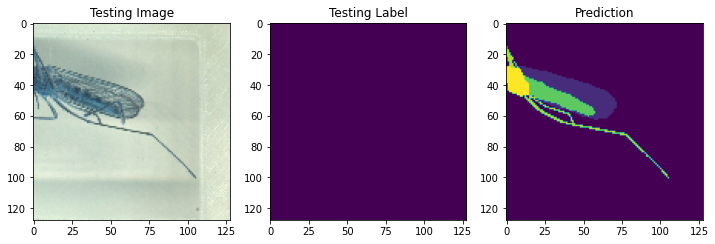

In [ ]:
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_train1[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model1.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction')
plt.imshow(predicted_img)
plt.show()

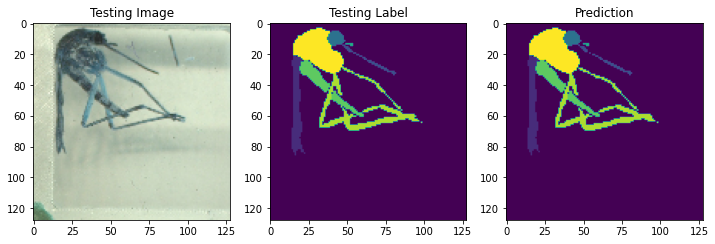

In [ ]:
import random
test_img_number = random.randint(0, len(X_train1))
test_img = X_train1[test_img_number]
ground_truth=y_train_cat_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model1.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction')
plt.imshow(predicted_img)
plt.show()